In [2]:
#!/usr/bin/env python

# Qin_wbgt-change-attribution-grid.ipynb

'''
    File name: Qin_wbgt-change-attribution-grid.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.30.2024
    Date last modified: 04.30.2024

    ############################################################## 
    Needs data from:
    The data that is used here was produced by Qinqin Kong <qqkong@stanford.edu>
    
    Purpose:

    1) Read in preprocessed data
    2) visualize the contributors to WBGT increases

'''

In [3]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import random
import math

import warnings
warnings.filterwarnings("ignore")

In [4]:
def solar_time_difference_from_utc(longitude):
    from datetime import datetime, timedelta, timezone
    """
    Calculate the difference between local solar time and UTC based on the given longitude.

    Args:
    - longitude (float): The longitude of the location in degrees (East is positive, West is negative).

    Returns:
    - time_difference (timedelta): The difference from UTC as a timedelta object.
    """
    # Calculate the time difference due to longitude (in minutes)
    time_difference_minutes = longitude * 4  # 4 minutes per degree

    # Create a timedelta object for the time difference
    time_difference = timedelta(minutes=time_difference_minutes)
    
    return time_difference

In [5]:
# read in constant fields
# read CONUS404 coordinates
ncid=Dataset('/glade/u/home/prein/projects/2020/2020_CONUS404/data/wrfconstants_d01_CONUS404.nc4', mode='r')
lon_conus = np.array(np.squeeze(ncid.variables['XLONG'][:]))
lat_conus = np.array(np.squeeze(ncid.variables['XLAT'][:]))
ncid.close()

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/data/wrfconstants_d01_CONUS404.nc4'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT")
LU = getvar(ncfile, "LU_INDEX")
cart_proj = get_cartopy(HGT_M)
ncid.close()

### User imput section

In [6]:
data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/grid_changes/'
tile_size = 10
# tile up the domain and locate the tile under investigation
nlon = math.ceil(lon_conus.shape[1]/tile_size)
nlat = math.ceil(lon_conus.shape[0]/tile_size)

### Load pre-processed data on the grid

In [7]:
qin_data = "/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/Qin_WBGT-decomposition/"
qin_files = ["temperature_contribution","specific_humidity_contribution","pressure_contribution",
             "wind_contribution", "solar_radiation_contribution", "wbgt_ctr", "wbgt_pgw"]
contribution = np.zeros((len(qin_files), lon_conus.shape[0], lon_conus.shape[1])); contribution[:] = np.nan
for va in tqdm(range(len(qin_files))):
    data = np.load(qin_data + qin_files[va] + ".npy")
    if len(data.shape) == 2:
        contribution[va, :,:] = data
    else:
        contribution[va, :,:] = np.mean(data, axis=0)

100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


In [8]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)


In [22]:
change_var_categories = ['T2 + LW','Q2','PSFC','UV10', 'SW']
change_cat_colors = ['#e31a1c','#1f78b4','#969696','#33a02c','#a6cee3','#fb9a99']
abc_array = list(string.ascii_lowercase)

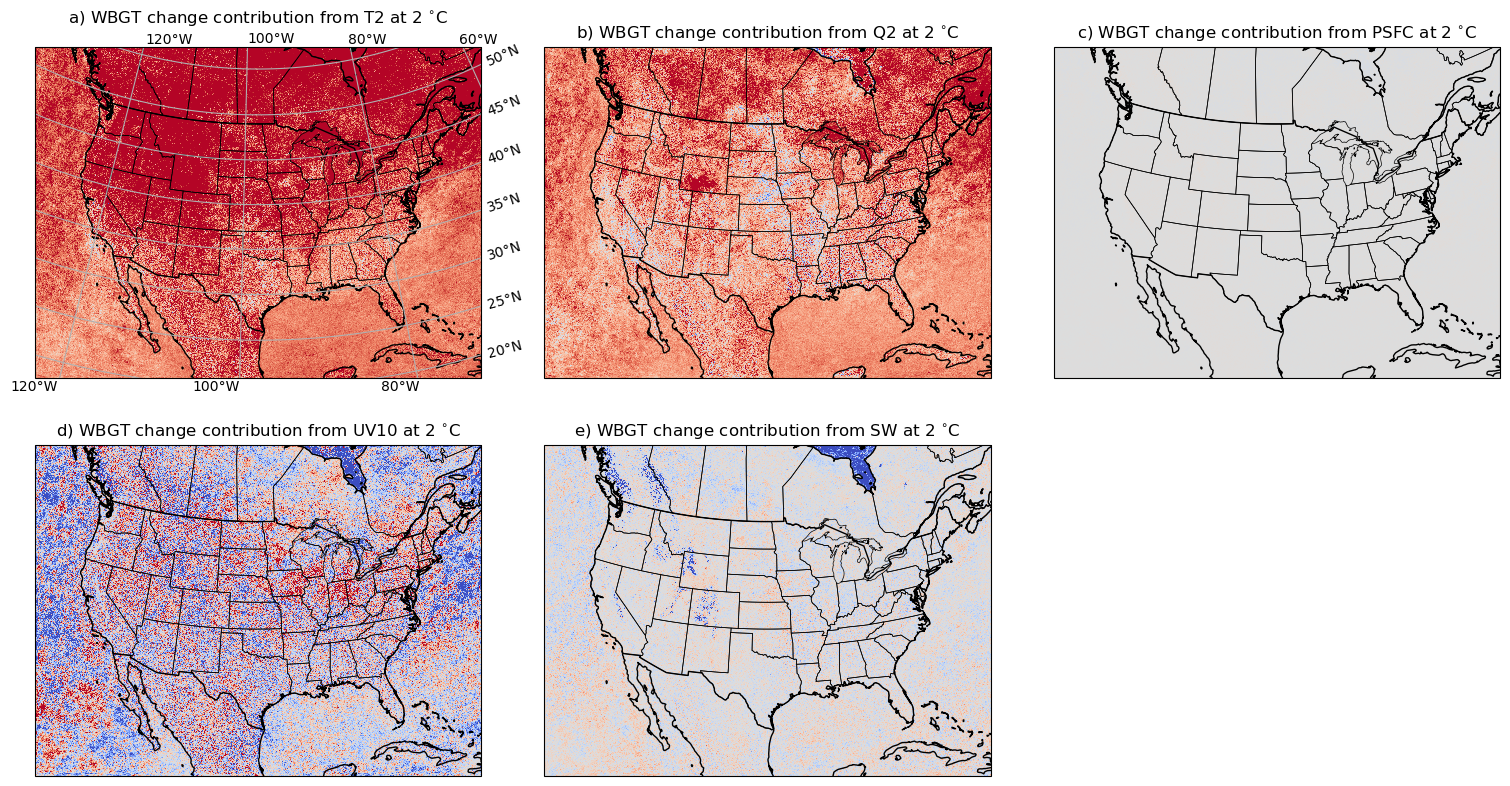

In [10]:
fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 10})
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.05, right=0.99,
           bottom=0.12, top=0.93,
           wspace=0.05, hspace=0.2)

xx = [0,1,2,0,1,2]
yy = [0,0,0,1,1,1]
for va in range(len(change_var_categories)):
    ax = plt.subplot(gs1[yy[va],xx[va]], projection=cart_proj)
    pos1 = ax.get_position()
    plt.title(abc_array[va] + ') WBGT change contribution from '+str(change_var_categories[va])+' at 2 $^{\circ}$C')
    
    plt.pcolormesh(lon_conus, lat_conus,
                   contribution[va,:,:], 
                   cmap="coolwarm", vmin=-1,vmax=1, transform=ccrs.PlateCarree()
                   )
    
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES, lw=0.5)

    if va == 0:
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels = False
        gl.xlabel_style = {'rotation': 0}

In [11]:
def coarsen(data,
            factor):
    data = np.reshape(data[:int(int(data.shape[0]/factor)*factor),
                           :int(int(data.shape[1]/factor)*factor)], 
                             (int(data.shape[0]/factor),
                             factor,
                             int(data.shape[1]/factor),
                             factor))
    return np.mean(data, axis = (1,3))

In [12]:
factor = 10
for va in range(len(change_var_categories)):
    data_act = contribution[va,:,:]
    if va == 0:
        A = np.abs(coarsen(data_act,factor))
    elif va == 1:
        B = np.abs(coarsen(data_act,factor))
    elif va == 2:
        C = np.abs(coarsen(data_act,factor))
    elif va == 3:
        D = np.abs(coarsen(data_act,factor))
    elif va == 4:
        E = np.abs(coarsen(data_act,factor))

In [13]:
"""
# Plot a 2D Color Table
ax1 = plt.axes([0.85, 0.7, 0.12, 0.12])

grid_size = 500
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y)

# Calculate gradients based on proximity to corners
resulting_colors = (
    (1 - X[..., None]) * (1 - Y[..., None]) * colors["A"] +
    X[..., None] * (1 - Y[..., None]) * colors["B"] +
    (1 - X[..., None]) * Y[..., None] * colors["D"] +
    X[..., None] * Y[..., None] * colors["E"]
)

# Plot the 2D color gradient
plt.pcolormesh(resulting_colors)
plt.title("2D Color Gradient Table", fontsize=16)
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.axis("off")  # Turn off axis for better visualization
"""

'\n# Plot a 2D Color Table\nax1 = plt.axes([0.85, 0.7, 0.12, 0.12])\n\ngrid_size = 500\nx = np.linspace(0, 1, grid_size)\ny = np.linspace(0, 1, grid_size)\nX, Y = np.meshgrid(x, y)\n\n# Calculate gradients based on proximity to corners\nresulting_colors = (\n    (1 - X[..., None]) * (1 - Y[..., None]) * colors["A"] +\n    X[..., None] * (1 - Y[..., None]) * colors["B"] +\n    (1 - X[..., None]) * Y[..., None] * colors["D"] +\n    X[..., None] * Y[..., None] * colors["E"]\n)\n\n# Plot the 2D color gradient\nplt.pcolormesh(resulting_colors)\nplt.title("2D Color Gradient Table", fontsize=16)\nplt.xlabel("X Coordinate", fontsize=12)\nplt.ylabel("Y Coordinate", fontsize=12)\nplt.axis("off")  # Turn off axis for better visualization\n'

In [14]:
# statistics for dominant change variable
var_max = np.argmax(np.abs(contribution[:-2,:]), axis=0)

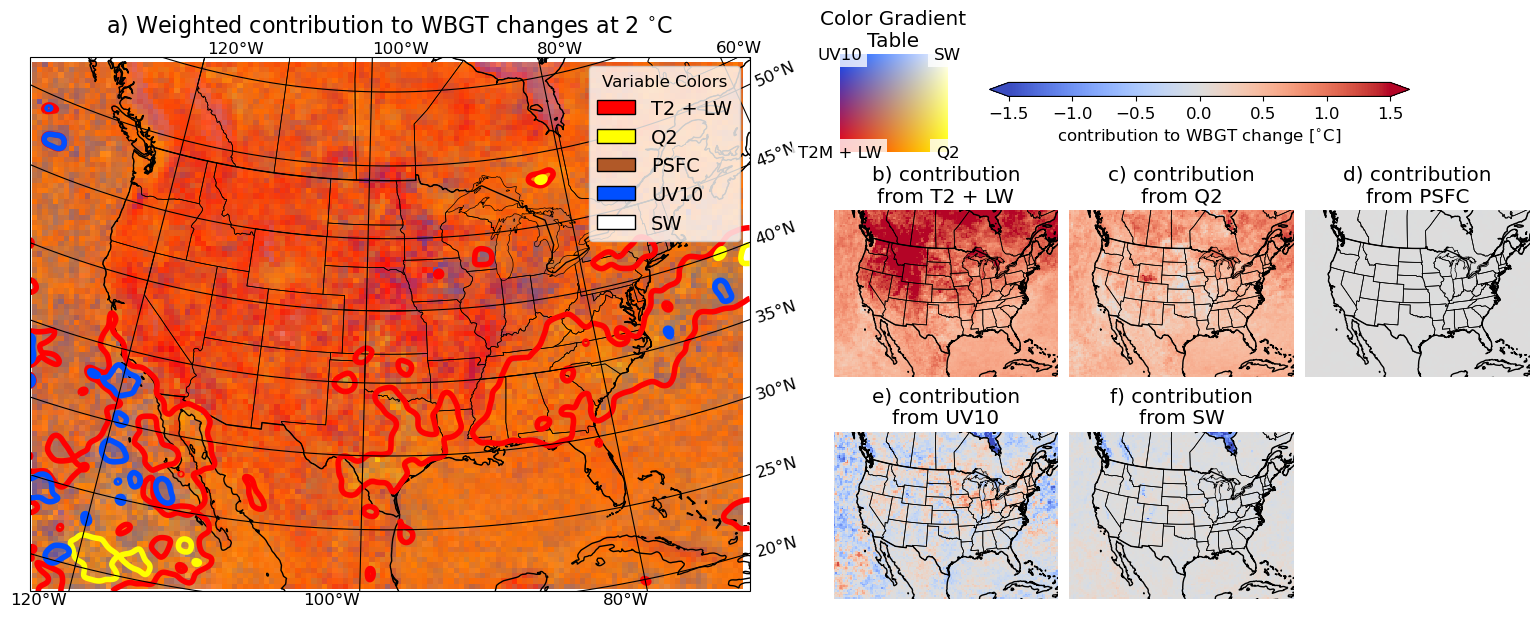

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import gridspec
from matplotlib.colors import ListedColormap

# Define the new colors
colors = {
    "A": np.array([255/255, 0/255, 0/255]),   # Red
    "B": np.array([255/255, 255/255, 0/255]), # Yellow
    "C": np.array([177/255, 89/255, 40/255]), # Orange
    "D": np.array([0/255, 79/255, 255/255]),  # Blue
    "E": np.array([1, 1, 1]),                # White
    "F": np.array([0/255, 169/255, 51/255]),  # Green
}


# Normalize contributions
total = A + B + C + D + E 
A, B, C, D, E = A / total, B / total, C / total, D / total, E / total

# Recalculate resulting colors
resulting_colors = (
    A[..., None] * colors["A"] +
    B[..., None] * colors["B"] +
    C[..., None] * colors["C"] +
    D[..., None] * colors["D"] +
    E[..., None] * colors["E"]
)

# Handle NaN or invalid values
resulting_colors = np.nan_to_num(resulting_colors, nan=1.0)  # Replace NaN with white (1, 1, 1)
resulting_colors = np.clip(resulting_colors, 0, 1)  # Ensure all values are in [0, 1]

# Convert resulting_colors to hex format
def rgb_to_hex(rgb):
    """Convert RGB array to hex string."""
    return "#{:02x}{:02x}{:02x}".format(
        int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255)
    )

reshaped_colors = resulting_colors.reshape(A.shape[0], A.shape[1], 3)
hex_colors = np.array([rgb_to_hex(color) for color in reshaped_colors.reshape(-1, 3)])

# Generate a scalar array to represent the grid
color_indices = np.arange(len(hex_colors)).reshape(A.shape[0], A.shape[1])

# Create a custom colormap from unique hex colors
unique_hex_colors = np.unique(hex_colors)
cmap = ListedColormap(unique_hex_colors)

# Map hex colors to indices
color_map = {color: idx for idx, color in enumerate(unique_hex_colors)}
scalar_data = np.array([color_map[color] for color in hex_colors]).reshape(A.shape[0], A.shape[1])

# Create figure and grid
fig = plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 12})
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=0.65, bottom=0.12, top=0.93, wspace=0.05, hspace=0.2)

# Plot the main weighted color contribution map
ax = plt.subplot(gs1[0, 0], projection=cart_proj)

# Use pcolormesh
X = coarsen(lon_conus,factor) #np.linspace(0, 1, original_change.shape[0])
Y = coarsen(lat_conus,factor)# np.linspace(0, 1, original_change.shape[1])
#X, Y = np.meshgrid(x, y)
ax.pcolormesh(
    X, Y, scalar_data[:-1,:-1],  # Dummy data for scalar grid
    cmap=cmap, shading="flat",   # Flattened RGB for each grid cell
    transform=ccrs.PlateCarree())

# dominant change variable
plt.contour(lon_conus, lat_conus, gaussian_filter((var_max == 0).astype("float"), 10), 
            levels=[0.5], colors="#ff0000", transform=ccrs.PlateCarree(), linewidths = 4)
plt.contour(lon_conus, lat_conus, gaussian_filter((var_max == 1).astype("float"), 10), 
            levels=[0.5], colors="#ffff00", transform=ccrs.PlateCarree(), linewidths = 4)
plt.contour(lon_conus, lat_conus, gaussian_filter((var_max == 3).astype("float"), 10), 
            levels=[0.5], colors="#004FFF", transform=ccrs.PlateCarree(), linewidths = 4)


plt.title("a) Weighted contribution to WBGT changes at 2 $^{\circ}$C", fontsize=16)
plt.xlabel("longitude [$^{\circ}$]", fontsize=12)
plt.ylabel("latitude [$^{\circ}$]", fontsize=12)

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color="k")
gl.left_labels = False
gl.xlabel_style = {'rotation': 0}

# Add legend
legend_elements = [
    Patch(facecolor=colors["A"], edgecolor='black', label=change_var_categories[0]),
    Patch(facecolor=colors["B"], edgecolor='black', label=change_var_categories[1]),
    Patch(facecolor=colors["C"], edgecolor='black', label=change_var_categories[2]),
    Patch(facecolor=colors["D"], edgecolor='black', label=change_var_categories[3]),
    Patch(facecolor=colors["E"], edgecolor='black', label=change_var_categories[4]),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=14, title="Variable Colors")


# Plot a 2D Color Table
ax1 = plt.axes([0.725, 0.77, 0.09, 0.14])

grid_size = 500
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y)

# Calculate gradients based on proximity to corners
resulting_colors = (
    (1 - X[..., None]) * (1 - Y[..., None]) * colors["A"] +
    X[..., None] * (1 - Y[..., None]) * colors["B"] +
    (1 - X[..., None]) * Y[..., None] * colors["D"] +
    X[..., None] * Y[..., None] * colors["E"]
)

# Plot the 2D color gradient
plt.pcolormesh(resulting_colors)

corner_labels = {
    "A": (0, 0, "T2M + LW"),
    "B": (1, 0, "Q2"),
    "D": (0, 1, "UV10"),
    "E": (1, 1, "SW")
}
for label, (x_pos, y_pos, text) in corner_labels.items():
    ax1.text(
        x_pos, y_pos, text,
        transform=ax1.transAxes,  # Use axis coordinates (0-1 range)
        fontsize=12, color='black', ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )



plt.title("Color Gradient\nTable") #, fontsize=16)
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.axis("off")  # Turn off axis for better visualization


####################################
####### individual changes

gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.72, right=1.3,
           bottom=0.12, top=0.7,
           wspace=0.05, hspace=0.2)

xx = [0,1,2,0,1,2]
yy = [0,0,0,1,1,1]
for va in range(len(change_var_categories)):
    ax = plt.subplot(gs1[yy[va],xx[va]], projection=cart_proj)
    pos1 = ax.get_position()
    plt.title(abc_array[va+1] + ') contribution\nfrom '+str(change_var_categories[va]))

    cs = plt.pcolormesh(coarsen(lon_conus,factor), coarsen(lat_conus,factor),\
                   coarsen(contribution[va,:],factor), 
                   cmap="coolwarm", vmin=-1.5, vmax=1.5, transform=ccrs.PlateCarree()
                   )

    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES, lw=0.5)
        
    plt.axis('off')

# Add a colour bar
CbarAx = plt.axes([0.85, 0.85, 0.35, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label('contribution to WBGT change [$^{\circ}$C]', fontsize=12)

fig.savefig('FigSXX_WBGT_change-contribution_linear-model.pdf', bbox_inches='tight')
plt.show()